# Day 15

## Part 1

- sensors and beacons sit at integer grid coordinates
- sensors know their own position and the position of the nearest beacon
- closest distances determined as Manhattan distances
- there is never a tie between beacon distances

`In the row where y=2000000, how many positions cannot contain a beacon?`

In [146]:
from matplotlib import pyplot as plt
from utils import parse_from_file, ParseConfig

parser = ParseConfig('\n', ParseConfig(': closest beacon is at x=', [
    ParseConfig('Sensor at x=', [None, ParseConfig(', y=', int)]),
    ParseConfig(', y=', int)
]))

sensor_data = parse_from_file('day_15.txt', parser)

print(sensor_data[:2])

[[[[220580, 684270]], [436611, 263737]], [[[3329538, 3016377]], [3355914, 2862466]]]


In [147]:
# remove the redundant list in list from parsing
temp = []
for (sensor, *_), (beacon) in sensor_data:
    temp.append((sensor, beacon))
sensor_data = temp

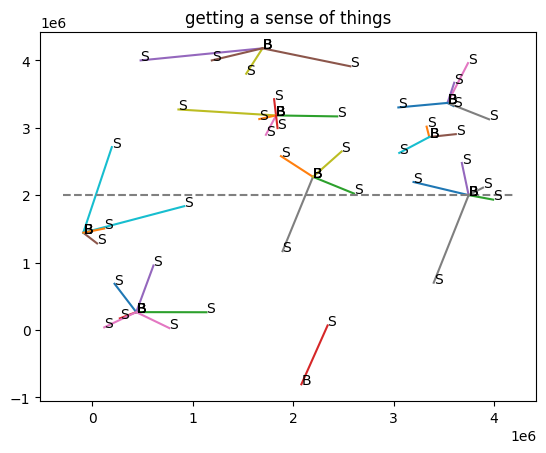

In [148]:
# lets take a look at this on a plot
fig, ax = plt.subplots()

row_to_investigate = 2000000

for (s_x, s_y), (b_x, b_y) in sensor_data:
    ax.plot((s_x, b_x), (s_y, b_y))
    ax.text(s_x, s_y, 'S')
    ax.text(b_x, b_y, 'B')
ax.set_title('getting a sense of things')
ax.plot(ax.get_xlim(), [row_to_investigate]*2, '--', color='gray')

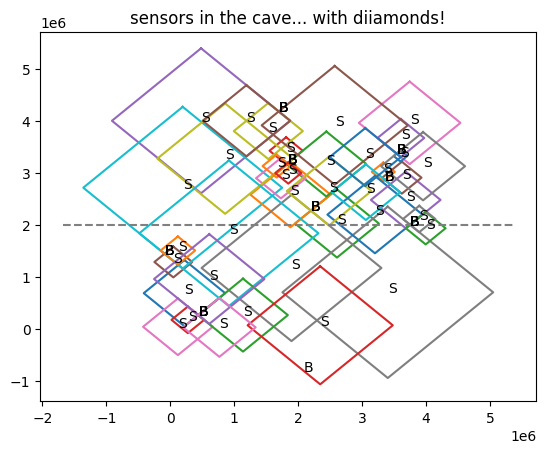

In [149]:
# let's do even better and get the Manhatten diamonds each sensor confirms
def get_bounds(sensor: tuple[int], beacon: tuple[int]) -> tuple[tuple[int]]:
    """
    returns the coordinates of the 4 vertecies of the Manhattan distance bound
    of each sensor beacon pair

    returns up twice for easy plotting
    """
    s_x, s_y = sensor
    b_x, b_y = beacon
    mh_dist = abs(s_x - b_x) + abs(s_y - b_y)
    up = (s_x, s_y + mh_dist)
    down = (s_x, s_y - mh_dist)
    left = (s_x - mh_dist, s_y)
    right = (s_x + mh_dist, s_y)
    return up, right, down, left, up

fig, ax = plt.subplots()
for sensor, beacon in sensor_data:
    ax.plot(*map(list, zip(*get_bounds(sensor, beacon))))
    ax.text(*sensor, 'S')
    ax.text(*beacon, 'B')
ax.set_title('sensors in the cave... with diiamonds!')
ax.plot(ax.get_xlim(), [row_to_investigate]*2, '--', color='gray')

In [150]:
# any sensors with diamonds that don't intersect y=2,000,000 can be disregarded
applicable_sensors = []
for sensor, beacon in sensor_data:
    bounds = get_bounds(sensor, beacon)
    (_, y2), _, (_, y1), *_ = bounds
    if y1 <= row_to_investigate <= y2:
        applicable_sensors.append((sensor, bounds))

In [151]:
# additionally, find any beacons which are on y=2,000,000 since those will 
# need to be subtracted from our total
temp = []
for _, (x, y) in sensor_data:
    if y == row_to_investigate:
        temp.append((x, y))

# there can only be one (of each beacon)!
applicable_beacons = set(temp)

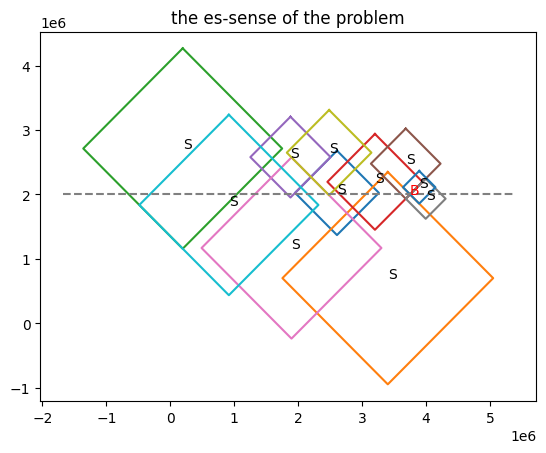

In [152]:
# so, what's the damage?
fig, ax = plt.subplots()
for sensor, bounds in applicable_sensors:
    ax.plot(*map(list, zip(*bounds)))
    ax.text(*sensor, 'S')
for beacon in applicable_beacons:
    ax.text(*beacon, 'B', color='red')
ax.set_title('the es-sense of the problem')
ax.plot(ax.get_xlim(), [row_to_investigate]*2, '--', color='gray')

In [153]:
# now all that's left is to find the total amount of y=2,000,000 that those
# diamonds cover
def get_accounted_for_bounds(
    sensor: tuple[int], bounds: tuple[tuple[int]], row: int
) -> tuple[int]:
    """
    returns min and max x values covered by this sensor at the row specified
    """
    s_x, s_y = sensor
    (_, u_y), *_ = bounds
    sensor_to_row = abs(s_y - row)
    mh_dist = abs(u_y - s_y)
    x_reach = mh_dist - sensor_to_row
    return s_x - x_reach, s_x + x_reach

x_bounds = []
x_min, x_max = None, None
for sensor, bounds in applicable_sensors:
    x1, x2 = get_accounted_for_bounds(sensor, bounds, row_to_investigate)
    x_bounds.append((x1, x2))
    if x_min is None or x1 < x_min:
        x_min = x1
    if x_max is None or x2 > x_max:
        x_max = x2

print(x_min, x_max)

-649258 4237112


In [154]:

row_state = [False for _ in range(x_min, x_max + 1)]

for x1, x2 in x_bounds:
    for index in range(x1 - x_min, x2 - x_min + 1):
        row_state[index] = True

total_without_beacons = sum(row_state) - len(applicable_beacons)

In [155]:
print(
    'the total number of integer positions without a beacon at row: ' \
    f'{row_to_investigate} is {total_without_beacons}'
)

the total number of integer positions without a beacon at row: 2000000 is 4886370


## Part 2

- the distress signal is within `x,y = [0, 4000000]`
- the tuning frequency is: `f = x * 4000000 + y`

`What is its tuning frequency?`

In [156]:
# we plotted all the bounds before but didn't actually save them
all_sensor_bounds = []
for sensor, beacon in sensor_data:
    all_sensor_bounds.append((sensor, get_bounds(sensor, beacon)))

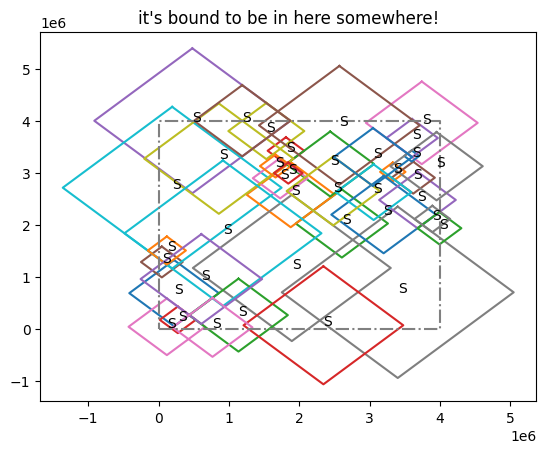

In [157]:
# lets see how that boundary lines up
distress_beacon_boundary = 4000000

plot_boundary = (
    (0, distress_beacon_boundary, distress_beacon_boundary, 0, 0),
    (0, 0, distress_beacon_boundary, distress_beacon_boundary, 0)
)
fig, ax = plt.subplots()
for sensor, bounds in all_sensor_bounds:
    ax.plot(*map(list, zip(*bounds)))
    ax.text(*sensor, 'S')
ax.set_title('it\'s bound to be in here somewhere!')
ax.plot(*plot_boundary, '-.', color='gray')


Text(0.5, 1.0, "I'm on the edge... of glory!")

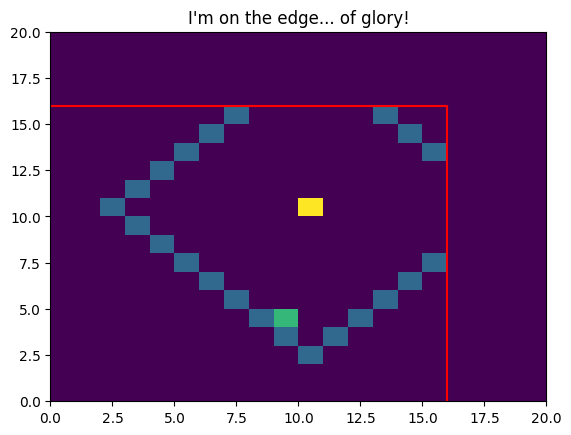

In [158]:
# doing this as a grid of values would take a very long time so we'll have to
# do it in a smarter way

# since there's only one possible location we can assume it'll be adjacent to
# a bound. this should reduce the problem by a factor of 1e6 *:P
def edge_points(sensor: tuple[int], beacon: tuple[int], search_bound):
    """
    a generator to spit out points adjacent to bounds of given a sensor and
    it's nearest beacon

    will skip values that are outside the search bounds and < 0
    """

    def in_bounds(x: int, y: int, search_bound: int) -> bool:
        """
        returns true if (x, y) is within the search boundary and above 0
        """
        return all([0 <= value <= search_bound for value in (x, y)])

    s_x, s_y = sensor
    b_x, b_y = beacon
    mh_dist = abs(s_x - b_x) + abs(s_y - b_y)
    # start from the top of a boundary
    x, y = s_x, s_y + mh_dist + 1
    # step down and right first
    step_x, step_y = 1, -1
    # check the first point
    if in_bounds(x, y, search_bound):
        yield x, y
    # update the point
    x += step_x
    y += step_y
    # if back at the start
    while not (x == s_x and y > s_y):
        # if at a x max (same operation for both sides)
        if y == s_y:
            step_x = -step_x
        # if at the lowest point
        elif x == s_x:  # (and x < s_y)
            step_y = -step_y
        # only yield if the value is within bounds
        if in_bounds(x, y, search_bound):
            yield x, y

        # update the point and loop
        x += step_x
        y += step_y

# let's test it
sensor = (10, 10)
beacon = (9, 4)
boundary = 15
grid = [[0 for _ in range(20)] for _ in range(20)]
x, y = sensor
grid[y][x] = 3
x, y = beacon
grid[y][x] = 2
for x, y in edge_points(sensor, beacon, boundary):
    grid[y][x] = 1

fig, ax = plt.subplots()
ax.pcolormesh(grid)
line_boundary = boundary + 1
ax.plot(
    (0, line_boundary, line_boundary), (line_boundary, line_boundary, 0),
    color='r'
)
ax.set_title('I\'m on the edge... of glory!')

In [159]:
# right, time to test it out for real!
def find_distress_signal(
    sensor_data: tuple[tuple[int]], search_boundary: int
) -> tuple[int]:
    """
    returns the coordinates of the only point not covered by the sensors passed
    """
    def mh_dist(coord_1: tuple[int], coord_2: tuple[int]) -> int:
        """
        returns the Manhattan distance between two (x, y) coordinates
        """
        (a, b), (x, y) = coord_1, coord_2
        return abs(a - x) + abs(b - y)

    # These values are reused alot so let's store them
    sensor_and_mh = []
    for sensor, beacon in sensor_data:
        sensor_and_mh.append((sensor, mh_dist(sensor, beacon)))

    for number_checked, (sensor, beacon) in enumerate(sensor_data, 1):
        print(
            f'{number_checked} / {len(sensor_data)} checked' + ' '*10, end='\r'
        )
        for edge_point in edge_points(sensor, beacon, search_boundary):
            # out of range until proven otherwise
            out_of_range = False
            for other_sensor, sensor_range in sensor_and_mh:
                if other_sensor == sensor:
                    continue
                if sensor_range >= mh_dist(other_sensor, edge_point):
                    # proven otherwise!
                    out_of_range = True
                    break
            if out_of_range == False:
                # if every sensor wasn't in range we've found our winner!
                return edge_point

distress_signal = find_distress_signal(sensor_data, distress_beacon_boundary)

Text(2843633, 2948438, 'B')

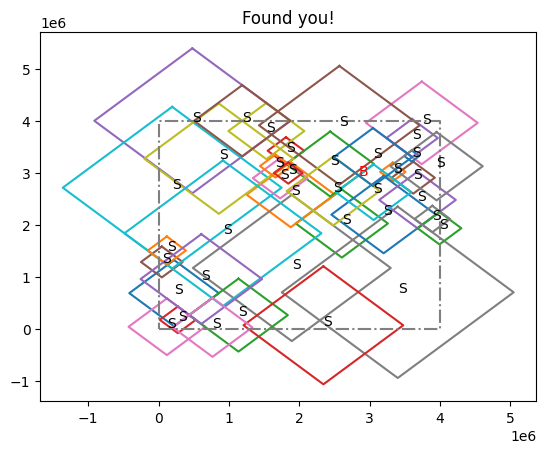

In [160]:
fig, ax = plt.subplots()
for sensor, bounds in all_sensor_bounds:
    ax.plot(*map(list, zip(*bounds)))
    ax.text(*sensor, 'S')
ax.set_title('Found you!')
ax.plot(*plot_boundary, '-.', color='gray')
ax.text(*distress_signal, 'B', color='red')

In [161]:
x, y = distress_signal
tuning_frequency = x * 4000000 + y

print(f'the tuning frequency is: {tuning_frequency}')

the tuning frequency is: 11374534948438
